# 赛题介绍

设法提高用户观看体验，是芒果TV平台的核心技术挑战之一，我们不断为此而努力！及时发现用户的兴趣和调整内容展示对于实现这一目标非常重要，在给定用户观影历史和上下文的行为的条件下，进行序列预测是一项非常重要且困难的推荐任务，本赛题将以此为背景，希望选手在真实样本数据集下建立出最优的序列预测模型。

## 赛题任务

根据大赛组织方提供的用户在芒果TV产生的行为，视频特征，标签特征等数据，构建模型，预测用户在芒果TV下一个时刻观看的视频。

## 数据说明

### 用户视频观看行为


## 评估指标

1. 评估指标是[MRR](https://en.wikipedia.org/wiki/Mean_reciprocal_rank)，将用户实际观看的视频排在更靠前的位置，将得到更高的分数。 
2. 算力要求 
    - 物理内存不超过256G，显存使用不超过11G。 
    - 代码运行时间不超过24小时。未满足以上算力限制的参赛队伍，大赛官方有权将最终总成绩判定无效，排名由后一名依次递补。

## 结果提交

每个did提交用户最有可能观看的6个视频，从高到低进行排序 
选手提交答案样例

| did  | vid   | rank |
| ---- | ----- | ---- |
| Did1 | Vid1  | 1    |
| Did1 | Vid3  | 2    |
| Did1 | Vid4  | 3    |
| Did1 | Vid7  | 4    |
| Did1 | Vid2  | 5    |
| Did1 | Vid5  | 6    |
| Did2 | Vid6  | 1    |
| Did2 | Vid7  | 2    |
| Did2 | Vid10 | 3    |
| Did2 | Vid32 | 4    |
| Did2 | Vid8  | 5    |
| Did2 | Vid9  | 6    |

请选手将测试集的预测结果按照上述文件样式进行提交上传，文件格式为csv，did列表示为用户，vid列表示用户下一个时刻观看的视频, rank是排序位置

## 比赛规则

1. 每支队伍每天限提交3次结果； 
2. 比赛排行按照B榜最终得分从高到低排序（如出现相同分数，按照推理耗时从低到高排序）； 
3. B榜赛程结束后，排名前10的队伍需要提交方案设计说明书、算法源代码。大赛官方组织专家进行审核和必要的沟通询问。 
4. 为防止作弊行为，主办方保留了部分未公开数据用于校验方案，如遇作弊行为，将取消选手成绩。

## 奖项设置

- 冠军：人民币240,000元
- 亚军：人民币60,000元
- 季军：人民币27,000元
- 排名第4至10名：人民币5,000元



# 数据读取

In [7]:
!ls ./data_v2/ -lh

总用量 552M
-rw-r--r-- 1 lyz lyz 433K 6月  20 11:21 candidate_items_A.csv
-rw-r--r-- 1 lyz lyz 507M 6月  20 11:19 main_vv_seq_train.csv
-rw-r--r-- 1 lyz lyz  44M 6月  20 11:18 vid_info.csv


In [3]:
%pylab inline

import os
import sys
import codecs
import pandas as pd
import numpy as np
from tqdm import tqdm


def read_data(path='data_v2/'):
    vid_info = pd.read_csv(os.path.join(path, 'vid_info.csv'))
    vid_info['stars'] = vid_info['stars'].apply(eval)
    vid_info['tags'] = vid_info['tags'].apply(eval)
    vid_info['key_word'] = vid_info['key_word'].apply(eval)
    vid_info.sort_values(by=['cid', 'serialno'], inplace=True)
    # vid_info.set_index('vid', inplace=True)

    seq_train = pd.read_csv(os.path.join(path, 'main_vv_seq_train.csv'))
    seq_train = seq_train.sort_values(by=['did', 'seq_no'])
    seq_train.reset_index(inplace=True)

    candidate_items = pd.read_csv(os.path.join(path, 'candidate_items_A.csv'))
    return vid_info, seq_train, candidate_items


vid_info, seq_train, candidate_items = read_data()

seq_vid_train = pd.merge(seq_train, vid_info, on='vid', how='left')
seq_vid_train['vts'] /= seq_vid_train['duration']
seq_vid_train['hb'] /= seq_vid_train['duration']

Populating the interactive namespace from numpy and matplotlib


In [2]:
vid_info.head(2)

,vid,cid,is_intact,serialno,classify_id,series_id,duration,title_length,upgc_flag,stars,tags,key_word
30044,49ce55753d994b17146098553a787982,00049722020c746dbc9164e52a7833b4,1,1,50,0,345,38,0,"[101031605, 101031603]",[105013965],"[189165, 369343, 747602, 407197, 865416, 24194..."
30045,2773a834f086b3ce6eca919f27211752,00049722020c746dbc9164e52a7833b4,1,2,50,0,214,38,0,"[101031605, 101031603]",[105013965],"[189165, 369343, 747602, 407197, 865416, 24194..."


In [3]:
seq_train.head(2)

,index,did,vid,vts,hb,seq_no,cpn,fpn,time_gap
0,2696560,0000d0aabe8c188f88c756ce0f7f9639,f87cf2ad695b4bb5dd830ae40bf29475,44.0,3286.0,1.0,1,130,NaN
1,2696559,0000d0aabe8c188f88c756ce0f7f9639,fde2b2a62fb6061e4a958fb0b78c0293,1260.0,3698.0,2.0,1,130,108.0


In [4]:
candidate_items.head(2)

,vid
0,5bc78a50602b520bb3f6c87e3c542f1c
1,73e37445d73561ffdf0711a3ffe4ca25


# 数据分析

## 视频信息表

| 字段        | 说明           | 示例                                                  | 备注                          |
| ----------- | -------------- | ----------------------------------------------------- | ----------------------------- |
| vid         | 视频id         | 239fa8776d81792a7477053184e7d6af                      | string                        |
| cid         | 合集id         | 9f84a64963ac7f263f56168b9b0819dc                      | string                        |
| Is_intact   | 视频类型       | 1                                                     | int                           |
| serialno    | 集号           | 1                                                     | int                           |
| series_id   | 系列id         | 0                                                     | int                           |
| duration    | 视频时长       | 1200                                                  | int                           |
| title_len   | 标题长度       | 30                                                    | int                           |
| upgc_flag   | upgc标识       | 0/1                                                   | int                           |
| classify_id | 频道类型       | 3                                                     | int(表示电影，电视剧，动漫等) |
| stars       | 包含的明星集合 | [101000001, 101000002, 101000005, 101000004,........] | array                         |
| keywords    | 关键词         | [0,4,5,78,9]                                          | array                         |
| tags        | 视频标签集合   | [201000001, 301000002, 401000005, 201000004,........] | array      

## 用户视频观看行为

| 字段     | 说明                          | 示例                             | 数据类型 |
| -------- | ----------------------------- | -------------------------------- | -------- |
| did      | 用户设备id                    | e55947fb8d27288721bbaaf90aea4766 | string   |
| vid      | 视频id                        | 239fa8776d81792a7477053184e7d6af | string   |
| vts      | 用户观看vid的播放时长         | 20                               | int      |
| hb       | 用户最后一次观看vid的进度时长 | 50                               | int      |
| seq_no   | 用户观看视频行为的序列号      | 1                                | int      |
| time_gap | 距离上一次观看视频的时间间隔  | 30                               | int      |
| cpn      | 当前页面类型                  | 12                               | int      |
| fpn      | 上一次跳转页面类型            | 1                                | int      |

<AxesSubplot:ylabel='Frequency'>

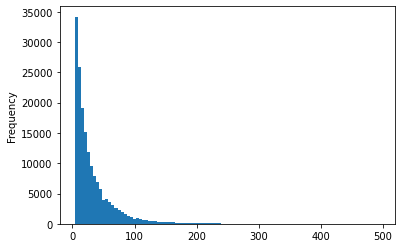

In [10]:
# 每个用户查看视频的vid的个数
seq_vid_train['did'].value_counts().plot(kind='hist', bins=100)

<AxesSubplot:ylabel='Frequency'>

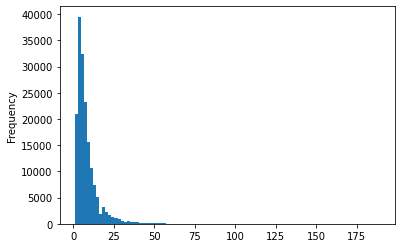

In [11]:
# 每个用户查看视频的cid的个数
seq_vid_train.groupby('did')['cid'].nunique().plot(kind='hist', bins=100)

<AxesSubplot:ylabel='Frequency'>

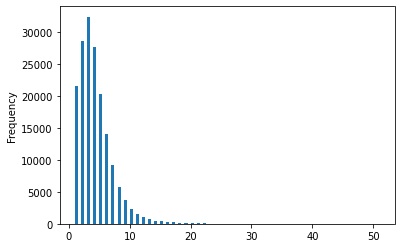

In [12]:
# 每个用户查看视频的series_id的个数
seq_vid_train.groupby('did')['series_id'].nunique().plot(
    kind='hist', bins=100)

In [13]:
# 热门vid拥有更多的观看率
seq_vid_train['vid'].value_counts() / seq_vid_train['did'].nunique()

dd4ad1276e13603b6a15704295ba6ec8    0.476768
0cc56b6914c87d906b23e6d90cd4f65e    0.359648
815a870db0d94166e330ae97f7068de2    0.225529
db978f94b983a6ed3021e1e927ee09ef    0.199913
7d697b54355da49d2a6949e9969bf828    0.196432
                                      ...   
2e0b8a702cb0edbf0ceb7a8f623401b0    0.000006
78e73c5dabb7df3875e0ec103e2336c9    0.000006
99300ebe9c68d78e17fec043408c1d85    0.000006
aa7368c717080d5f1a7f3f6c3bac08fe    0.000006
a84a780911a583e8e62fce0f90d4e1c1    0.000006
Name: vid, Length: 147074, dtype: float64

# 用户行为划分

- 用户历史都观看同一个cid、series_id的视频，且视频序列中 serialno 不断增加，用户占比4%

- 用户最近观看cid、series_id的视频
    - 存在跳serialno观看的行为
    - 中间有查看其他cid、series_id的视频


- 用户最近观看cid、series_id的视频，看完了所有的serialno
    - 看完了再次重头看
    - 看新的视频
    
# 召回策略

1. 使用vid关联规则【统计】
    - 计算与最后vid关联性最大的下一个vid；
    - 计算与最后5个vid关联性最大的下一个vid；
    - 计算与历史观看时间最长的vid关联性最大的下一个vid；
2. 使用vid计算词向量相似度


# 本地验证集划分

In [9]:


# seq_vid_train.drop(['cpn', 'fpn', 'is_intact', 'title_length', 'duration',
#                     'upgc_flag', 'stars', 'tags', 'key_word'], axis=1, inplace=True)

# vid 本身特征
# seq_train_info['vid_freq'] = seq_train_info['vid'].map(
#     seq_train_info['vid'].value_counts())

# seq_train_info['cid_max'] = seq_train_info['cid'].map(
#     vid_info.groupby('cid')['serialno'].max())

In [4]:
did_max_seq_no = seq_vid_train.groupby('did')['seq_no'].max().reset_index()
seq_local_valid = pd.merge(seq_vid_train, did_max_seq_no, on=['did', 'seq_no'])
seq_local_train = seq_vid_train[~seq_vid_train['index'].isin(
    seq_local_valid['index'])]

seq_local_valid.set_index('did', inplace=True)

In [15]:
seq_local_valid.loc['0002bcdd4bbf19b44c9badc817b160ed']

index                                                      537809
vid                              50999680985c2e4b8e1ca38a23496571
vts                                                      0.749654
hb                                                       0.903926
seq_no                                                         18
cpn                                                             1
fpn                                                            68
time_gap                                                     1751
cid                              644de3dce40c823149df609c0dde5b6d
is_intact                                                       1
serialno                                                       11
classify_id                                                     1
series_id                                                       0
duration                                                     6495
title_length                                                   97
upgc_flag 

In [16]:
seq_local_valid.shape, seq_local_train.shape, seq_vid_train.shape

((170909, 19), (5425504, 20), (5596413, 20))

In [17]:
hot20 = seq_local_valid['vid'].value_counts().head(50).index
hot20 = list(hot20)

In [18]:
seq_train

,index,did,vid,vts,hb,seq_no,cpn,fpn,time_gap
0,2696560,0000d0aabe8c188f88c756ce0f7f9639,f87cf2ad695b4bb5dd830ae40bf29475,44.0,3286.0,1.0,1,130,NaN
1,2696559,0000d0aabe8c188f88c756ce0f7f9639,fde2b2a62fb6061e4a958fb0b78c0293,1260.0,3698.0,2.0,1,130,108.0
2,2696558,0000d0aabe8c188f88c756ce0f7f9639,2c47a9311f2f19d6b33670715cdc544d,780.0,7715.0,3.0,1,130,57645.0
3,2696557,0000d0aabe8c188f88c756ce0f7f9639,bee6becd984e6486215f7acd876b5d26,2714.0,2611.0,4.0,1,68,546847.0
4,2696556,0000d0aabe8c188f88c756ce0f7f9639,449a1829a8742e652cb39d6ae7523df1,1620.0,1983.0,5.0,1,130,3103.0
...,...,...,...,...,...,...,...,...,...
5596408,2845463,ffff856232794b1cff1baea25bc25786,f3ff5b300b1d9678a7d9854e690e25b9,695.0,2531.0,65.0,1,130,863.0
5596409,2845462,ffff856232794b1cff1baea25bc25786,3d3a565c086dc00a8fb9eb3ad8876ce9,741.0,2228.0,66.0,1,130,680.0
5596410,2845461,ffff856232794b1cff1baea25bc25786,f6abae9373d6adfc32f5ea6d37e5fb17,900.0,2236.0,67.0,1,26,3278.0
5596411,2845460,ffff856232794b1cff1baea25bc25786,aa09d0cf8a2c89d82d2909027897e657,360.0,2263.0,68.0,1,26,1085.0


## 相似度计算

In [29]:
from gensim.models import Word2Vec
vid_list = seq_train.groupby(['did'])['vid'].apply(list).values
vid_w2v = Word2Vec(sentences=vid_list[:], window=5, min_count=1, workers=8)

# time gap 可以作为序列拆分

In [5]:
tmp_seq_train = seq_train[['did', 'vid']]
tmp_seq_train['vid_next1'] = tmp_seq_train.groupby(['did']).vid.shift(-1)
tmp_seq_train['vid_next2'] = tmp_seq_train.groupby(['did']).vid.shift(-2)

vid_next1 = tmp_seq_train.groupby(['vid', 'vid_next1']).size(
).sort_values(ascending=False).reset_index()
vid_next1 = vid_next1[vid_next1[0] > 100]
vid_next1.set_index('vid', inplace=True)
vid_next1 = vid_next1.sort_values(by=['vid', 0], ascending=False)
vid_next1 = vid_next1.groupby('vid')['vid_next1'].apply(list).to_dict()

vid_next2 = tmp_seq_train.groupby(['vid', 'vid_next1', 'vid_next2']).size(
).sort_values(ascending=False).reset_index()
vid_next2 = vid_next2[vid_next2[0] > 100]
vid_next2['vid'] = vid_next2['vid'] + vid_next2['vid_next1']
vid_next2 = vid_next2[['vid', 'vid_next2', 0]]
vid_next2 = vid_next2.sort_values(by=['vid', 0], ascending=False)
vid_next2 = vid_next2.groupby('vid')['vid_next2'].apply(list).to_dict()

/home/lyz/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/lyz/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


# 模型构建

## 模型1：策略推荐

In [32]:
mrr = []

for did, did_seq_train in tqdm(seq_local_train.groupby('did')):
    last1_vid = did_seq_train['vid'].iloc[-1]
    hist_vid = list(did_seq_train['vid'])
    cid_nunique = did_seq_train['cid'].nunique()

    candidate_vid = []
    if last1_vid in vid_next1:
        candidate_vid = vid_next1[last1_vid][:]
    else:
        candidate_vid = []

    if len(candidate_vid) == 0:
        w2v_sim = vid_w2v.wv.most_similar(hist_vid[-1])
        w2v_sim = [x[0] for x in w2v_sim][:3]
        pred_vid = w2v_sim + hot20
    else:
        pred_vid = candidate_vid
        pred_vid = pred_vid + hot20

    pred_vid = [x for x in pred_vid if x not in hist_vid]
    pred_vid = list(dict.fromkeys(pred_vid))[:6]
    try:
        pred_result = pred_vid.index(seq_local_valid.loc[did]['vid'])
        mrr.append(1/(pred_result + 1))
    except:
        mrr.append(0)

    if len(mrr) > 10000:
        break
        
#     break
    
np.mean(mrr)

  6%|▌         | 10000/170909 [00:14<03:55, 683.56it/s]


0.39836016398360163

In [33]:
rule_submit = []
for did, did_seq in tqdm(seq_vid_train.groupby('did'), total=seq_train['did'].nunique()):
    last1_vid = did_seq['vid'].iloc[-1]
    hist_vid = list(did_seq['vid'])
    cid_nunique = did_seq['cid'].nunique()

    pred_result = []
    if last1_vid in vid_next1:
        pred_result = vid_next1[last1_vid][:]

    if len(pred_result) == 0:
        w2v_sim = vid_w2v.wv.most_similar(hist_vid[-1])
        w2v_sim = [x[0] for x in w2v_sim][:3]
        pred_result = w2v_sim

    pred_result += hot20
    pred_result = list(dict.fromkeys(pred_result))
    pred_result = [x for x in pred_result if x not in hist_vid]
    rule_submit += [[did, x] for x in pred_result]


100%|██████████| 170909/170909 [03:20<00:00, 853.61it/s] 


In [34]:
rule_submit2 = pd.DataFrame(rule_submit)
rule_submit2 = rule_submit2[rule_submit2[1].isin(candidate_items['vid'])]

In [35]:
rule_submit2 = rule_submit2.drop_duplicates(keep='first')

In [36]:
rule_submit2 = rule_submit2.groupby(0).head(6)
rule_submit2.columns = ['did', 'vid']
rule_submit2['rank'] = rule_submit2.groupby('did').cumcount()+1
rule_submit2.to_csv('res.csv', index=None)

In [37]:
rule_submit2['did'].value_counts()

d2964663b3b8aa06c6fe1a66838e8ef8    6
4f9a18d61efe3223afbb21669bd3eddd    6
281dc7301c214824659e8d259b9b6957    6
52c109cd66f568e4a42b3d91bb834d03    6
baa9bf96009c26a03e4db8ede1f3647c    6
                                   ..
70926cc3f29e3b79084e813bd244a3ca    6
6d91285c8c0e12045d8301061f1e8c6c    6
9c0f6e108fec513f7a5488555a8075ec    6
7f810619191c68e504b029a2b4ce6de0    6
cc6a793a9324a905c302b4b04484335b    6
Name: did, Length: 170909, dtype: int64

In [38]:
!wc -l res.csv

1025455 res.csv


In [39]:
!zip -r res.csv.zip res.csv

updating: res.csv (deflated 84%)
